In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import shapely
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
from pathlib import Path

pd.options.display.max_columns = None
pd_max_colwidth_original = pd.options.display.max_colwidth
# pd.options.display.max_colwidth = None
gpd.options.io_engine = "pyogrio"

In [2]:
states_provinces_to_drop = ["HI", "AK", "YT", "NU", "NT", "BC", "AB", "SK", "MB", "ON", "QC", "NB", "NL", "PE"]

In [3]:
directory_location = r'../../Truck_Areas/'
faf_nodes_df = gpd.read_file(r'zip://' + directory_location + 'FAF5_Model_Highway_Network.zip!Networks/Geodatabase Format/FAF5Network.gdb/a0000000a.gdbtable')
print(f'Number of nodes prior to dropping duplicates: {len(faf_nodes_df)}')
faf_nodes_df.drop_duplicates(inplace=True)
print(f'Number of nodes after dropping duplicates: {len(faf_nodes_df)}')

Number of nodes prior to dropping duplicates: 974788
Number of nodes after dropping duplicates: 348495


In [4]:
# This cell does very little because the "State" field in the faf_nodes_df is almost never populated with the state

faf_nodes_df.drop(faf_nodes_df[faf_nodes_df.State.isin(states_provinces_to_drop)].index, inplace=True)
faf_nodes_df.reset_index(drop=True, inplace=True)
print(f'Number of nodes after dropping HI, AK and Canada: {len(faf_nodes_df)}')

Number of nodes after dropping HI, AK and Canada: 348442


In [5]:
faf_links_df = gpd.read_file(r'zip://' + directory_location + 'FAF5_Model_Highway_Network.zip!Networks/Geodatabase Format/FAF5Network.gdb/a00000009.gdbtable')
# Take out Canada, Alaska, Hawaii
faf_links_df.drop(faf_links_df[faf_links_df.STATE.isin(states_provinces_to_drop)].index, inplace=True)

In [6]:
print(f'faf_links_df.csr: {faf_links_df.crs}')
print(f'faf_nodes_df.csr: {faf_nodes_df.crs}')
print(f'faf_links_df.shape: {faf_links_df.shape}')
print(f'faf_nodes_df.shape: {faf_nodes_df.shape}')
print(f'len(faf_links_df): {len(faf_links_df)}')
print(f'len(faf_nodes_df): {len(faf_nodes_df)}')
print(f'len(faf_links_df.columns): {len(faf_links_df.columns)}')
print(f'len(faf_nodes_df.columns): {len(faf_nodes_df.columns)}')

faf_links_df.csr: EPSG:4269
faf_nodes_df.csr: EPSG:4269
faf_links_df.shape: (482688, 53)
faf_nodes_df.shape: (348442, 16)
len(faf_links_df): 482688
len(faf_nodes_df): 348442
len(faf_links_df.columns): 53
len(faf_nodes_df.columns): 16


In [7]:
def build_node_to_link_structures() -> tuple[list[int], list[int], dict[tuple[float, float], int]]:
    faf_links_df.reset_index(drop=True, inplace=True)
    faf_nodes_df.reset_index(drop=True, inplace=True)
    _node_lat_long_to_idx = {(row.geometry.coords[0][1], row.geometry.coords[0][0]): row.Index for row in faf_nodes_df.itertuples(index=True)}
    _from_node_idx: list[int] = list()
    _to_node_idx: list[int] = list()
    links_with_no_valid_nodes: list[tuple[int, str, str, str, int, int]] = list()
    for row in faf_links_df.itertuples(index=True):
        if shapely.get_num_geometries(row.geometry) > 1:
            print(row)
        linestring = shapely.get_geometry(row.geometry, 0)
        one_end_point = (linestring.coords[0][1], linestring.coords[0][0])
        other_end_point = (linestring.coords[-1][1], linestring.coords[-1][0])
        one_end_point_idx = _node_lat_long_to_idx[one_end_point] if one_end_point in _node_lat_long_to_idx else -1
        other_end_point_idx = _node_lat_long_to_idx[other_end_point] if other_end_point in _node_lat_long_to_idx else -1
        _from_node_idx.append(one_end_point_idx)
        _to_node_idx.append(other_end_point_idx)
        
        if one_end_point_idx == -1 or other_end_point_idx == -1:
            links_with_no_valid_nodes.append((row.ID, row.Country, row.STATE, row.Road_Name, one_end_point_idx, other_end_point_idx))
        
    faf_links_df['FROM_NODE_IDX'] = _from_node_idx
    faf_links_df['TO_NODE_IDX'] = _to_node_idx
    print(f'Links with no valid nodes: {links_with_no_valid_nodes}')
    return _from_node_idx, _to_node_idx, _node_lat_long_to_idx


In [8]:
from_node_idx, to_node_idx, node_lat_long_to_idx = build_node_to_link_structures()

print("num different from-nodes, num different to-nodes, number of combined from/to nodes")
node_idx_used_by_links = set(from_node_idx) | set(to_node_idx)
len(set(from_node_idx)), len(set(to_node_idx)), len(node_idx_used_by_links)

Links with no valid nodes: []
num different from-nodes, num different to-nodes, number of combined from/to nodes


(333745, 333251, 344929)

In [9]:
node_idx_not_used_by_links = set(node_lat_long_to_idx.values()) - node_idx_used_by_links
len(node_idx_not_used_by_links)

3513

In [10]:
# Display all the nodes not used by links - they should all be in Alaska or Hawaii
# faf_nodes_df.iloc[list(node_idx_not_used_by_links)].explore()

In [11]:
# Drop the nodes not used by the links.  These are HI, AK and Canadian nodes
faf_nodes_df.drop(list(node_idx_not_used_by_links), inplace=True)
from_node_idx, to_node_idx, node_lat_long_to_idx = build_node_to_link_structures()
print(f'Final node count: {len(faf_nodes_df)}')

Links with no valid nodes: []
Final node count: 344929


US counties shapefile:  https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=Counties+%28and+equivalent%29 (click on the download button) or find it: https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/

In [12]:
counties_df = gpd.read_file(directory_location + "tl_2017_us_county.zip")  # US counties shapefile
counties_df = counties_df.astype({'INTPTLAT': float, 'INTPTLON': float})

In [13]:
counties_df.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,41.915865,-96.788517,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,46.294638,-123.424458,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."


In [14]:
nx_highway_graph = nx.DiGraph()

edge_idx_counter = 0
for row in faf_links_df.itertuples(index=True):

    origin_node_idx = row.FROM_NODE_IDX
    destination_node_idx = row.TO_NODE_IDX
    if origin_node_idx == -1 or destination_node_idx == -1:
        continue

    origin_node = faf_nodes_df.loc[origin_node_idx]
    destination_node = faf_nodes_df.loc[destination_node_idx]

    # add the nodes with the right attributes to be used by dyntapy
    if origin_node_idx not in nx_highway_graph.nodes:
        nx_highway_graph.add_node(
            origin_node_idx, x_coord=origin_node.geometry.coords[0][0], y_coord=origin_node.geometry.coords[0][1])
    if destination_node_idx not in nx_highway_graph.nodes:
        nx_highway_graph.add_node(
            destination_node_idx, x_coord=destination_node.geometry.coords[0][0], y_coord=destination_node.geometry.coords[0][1])

    # add the edges with the right attributes to be used by dyntapy
    # ‘from_node_id’, ‘to_node_id’, ‘link_id’, ‘lanes’, ‘capacity’, ‘length’, ‘free_speed’
    length_miles = row.LENGTH
    ab_lanes = 0 if (np.isnan(row.AB_Lanes) or row.AB_Lanes <
                     1) else row.AB_Lanes  # many links have NaN or 0 lanes
    ba_lanes = 0 if (np.isnan(row.BA_Lanes) or row.BA_Lanes < 1) else row.BA_Lanes
    ab_edge = {
        'u_of_edge': origin_node_idx,             # networx requires this attribute
        'v_of_edge': destination_node_idx,        # networx requires this attribute
        'from_node_id': origin_node_idx,
        'to_node_id': destination_node_idx,
        'link_id': row.Index,
        'lanes': ab_lanes,
        'length': length_miles,
        'free_speed': row.AB_FinalSpeed,  # still not sure of this
        'capacity': ab_lanes*22000
    }
    ba_edge = {
        'u_of_edge': destination_node_idx,        # networx requires this attribute
        'v_of_edge': origin_node_idx,             # networx requires this attribute
        'from_node_id': destination_node_idx,
        'to_node_id': origin_node_idx,
        'lanes': ba_lanes,
        'length': length_miles,
        'free_speed': row.BA_FinalSpeed,  # still not sure of this
        'capacity': ba_lanes*22000
    }

    if row.DIR == 1:  # A-> B only
        ab_edge["link_id"] = edge_idx_counter
        nx_highway_graph.add_edge(**ab_edge)
        edge_idx_counter += 1

    elif row.DIR == -1:  # B->A only
        ba_edge["link_id"] = edge_idx_counter
        nx_highway_graph.add_edge(**ba_edge)
        edge_idx_counter += 1

    else:
        # add A->B
        ab_edge["link_id"] = edge_idx_counter
        nx_highway_graph.add_edge(**ab_edge)
        edge_idx_counter += 1

        # add B->A
        ba_edge["link_id"] = edge_idx_counter
        nx_highway_graph.add_edge(**ba_edge)
        edge_idx_counter += 1

print(f"edges {edge_idx_counter:,}")

edges 648,982


In [15]:
print(f"Is graph strongly connected: {nx.is_strongly_connected(nx_highway_graph)}")
print(f"Number of strongly connected components {len([x for x in nx.strongly_connected_components(nx_highway_graph)]):,}")
print(f"Number of weekly connected components {len([x for x in nx.weakly_connected_components(nx_highway_graph)]):,}")

Is graph strongly connected: False
Number of strongly connected components 14,951
Number of weekly connected components 151


In [16]:
s_components = [x for x in nx.strongly_connected_components(nx_highway_graph)]
[(idx, len(x)) for idx, x in enumerate(s_components) if len(x) > 1]

[(11, 10),
 (58, 9),
 (291, 2),
 (608, 2),
 (3854, 4),
 (6438, 2),
 (7464, 329931),
 (7769, 6),
 (7814, 2),
 (7835, 2),
 (8700, 4),
 (8884, 2),
 (10547, 2),
 (11045, 2),
 (11290, 2),
 (13298, 2),
 (14073, 2),
 (14289, 2),
 (14855, 4),
 (14857, 5),
 (14888, 2)]

In [17]:
w_components = [x for x in nx.weakly_connected_components(nx_highway_graph)]
largest_component = max(w_components, key=len)
len(largest_component)

344604

In [18]:
largest_highway_graph = nx_highway_graph.subgraph(largest_component)
node_lat_longs = {node: (long, lat) for (node, long, lat) in zip(nx.get_node_attributes(largest_highway_graph, 'x_coord').keys(),
                                                                 nx.get_node_attributes(
                                                                     largest_highway_graph, 'x_coord').values(),
                                                                 nx.get_node_attributes(largest_highway_graph, 'y_coord').values())}

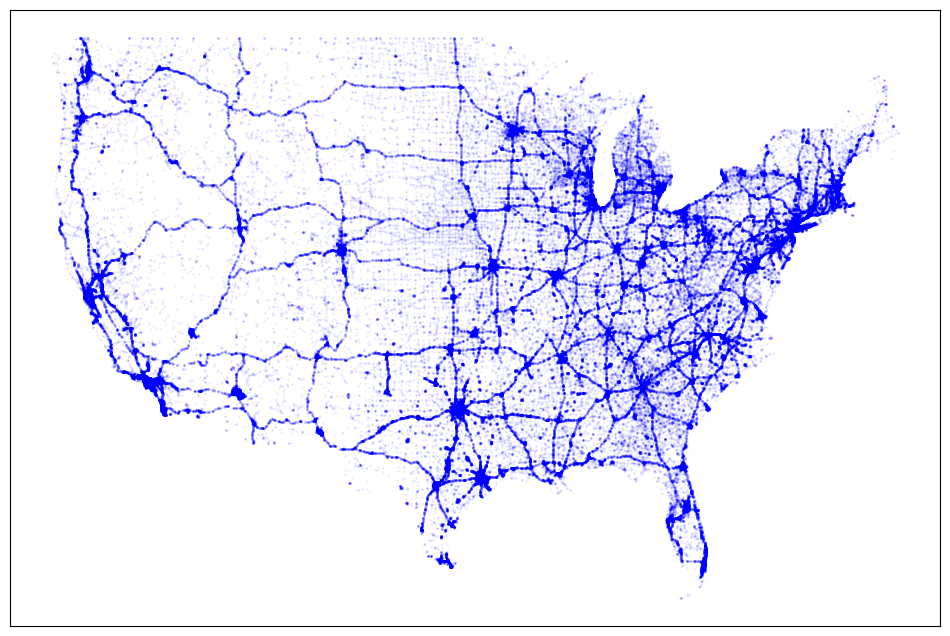

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
nx.draw_networkx_nodes(largest_highway_graph,node_lat_longs,node_size=1,node_color='blue',ax=ax, alpha=0.05)

In [20]:
# create ball tree from nodes of largest_highway_graph
# we need to find where on the highway graph to connect the centroids
# construct a ball tree based on the highway graph data
highway_node_lat_long_radians = np.deg2rad(np.array(list(node_lat_long_to_idx.keys())))
highway_node_ball_tree = BallTree(highway_node_lat_long_radians, metric='haversine')

In [21]:
montgomery_county_pa = counties_df[counties_df.GEOID == "42091"]
montgomery_county_pa
montco_pa_centroid_deg = list(zip(montgomery_county_pa.INTPTLAT, montgomery_county_pa.INTPTLON))
montco_pa_centroid_deg

[(40.2099992, -75.3702011)]

In [22]:
RADIUS_EARTH_MILES = 3958.8

montgomery_county_pa_centroid = np.deg2rad(montco_pa_centroid_deg)
print(montgomery_county_pa_centroid)
distances, indices = highway_node_ball_tree.query(montgomery_county_pa_centroid, k=20, return_distance=True)
print(distances.squeeze()*RADIUS_EARTH_MILES)
faf_nodes_df.iloc[indices.squeeze()].explore(style_kwds={'weight': 10})

[[ 0.70179688 -1.31545817]]
[1.38705491 2.10696072 2.27127384 2.88111392 2.89928638 2.98939086
 3.05627827 3.07176403 3.13318959 3.13862608 3.239102   3.26211128
 3.2739449  3.29675417 3.32552112 3.3712514  3.61771834 4.13723131
 4.14902291 4.17824702]


In [25]:
centroid_x = np.array([row.INTPTLON for row in counties_df.itertuples()])
centroid_y = np.array([row.INTPTLAT for row in counties_df.itertuples()])

In [ ]:
# input 1
county_od = pd.read_parquet('../data/transformed/county_od.parquet')

In [ ]:
# input 2
target_path = CACHE_PATH /  'data/raw/us_county_shp_files.zip'
county_gdf = pyogrio.read_dataframe(target_path, use_arrow=True)

In [ ]:
# let's start with a small portion of the ODs to see if we can get it to work
OD_QUANTILE_THRESHOLD = .999
# OD_QUANTILE_THRESHOLD = None
if OD_QUANTILE_THRESHOLD:
    tons_threshold = county_od['tons'].quantile(OD_QUANTILE_THRESHOLD)
    subset_county_od = county_od.loc[county_od['tons'] > tons_threshold]
else:
    subset_county_od = county_od
len(subset_county_od)

In [ ]:
# Now we need to figure out where in each county we want a "connector" [a location from which tons will attach to the transport graph]
# right now, we're using the "actual" geometric centroid as the "connector" location  in the county but we could refine this in the future
# based on where in the county we expect things to be originating from and/or how many "connectors" we want to have within each county
county_gdf = county_gdf.to_crs("EPSG:5070") # albers

In [ ]:
county_gdf['centroid'] = county_gdf.geometry.centroid.to_crs("EPSG:4326") # in lat/long

In [ ]:
%%time
# create a dict of (statefp,countyfp) => connector latitude, connector longitude [right now this is only using a SINGLE connector]
county_to_node_dict = dict()
county_to_node_idx_dict = dict()
for idx, row in enumerate(county_gdf.itertuples()):
    county_to_node_dict[(row.STATEFP,row.COUNTYFP)]=(round_to_digits(row.centroid.y), round_to_digits(row.centroid.x))
    county_to_node_idx_dict[(row.STATEFP,row.COUNTYFP)] = idx

In [ ]:
%%time
od_graph = nx.DiGraph()
for row in subset_county_od.itertuples():
    # get the origin and destination identifiers
    origin_node, destination_node = (row.state_orig, row.county_orig), (row.state_dest, row.county_dest)

    # extract the node latitudes and longitudes and indices from pre-computed dictionaries
    origin_latitude, origin_longitude = county_to_node_dict[origin_node]
    destination_latitude, destination_longitude = county_to_node_dict[destination_node]
    origin_node_idx,destination_node_idx = county_to_node_idx_dict[origin_node], county_to_node_idx_dict[destination_node]

    # add the nodes and edges with the right attributese to be used by dyntapy
    od_graph.add_node(origin_node_idx, x_coord=origin_longitude, y_coord=origin_latitude)
    od_graph.add_node(destination_node_idx, x_coord=destination_longitude, y_coord=destination_latitude)
    od_graph.add_edge(origin_node_idx, destination_node_idx, flow=row.tons)

print(f"OD graph: num nodes ({len(od_graph.nodes):,}), edges ({len(od_graph.edges):,})")

In [ ]:
%%time
# serialize the OD graph
nx.write_gml(od_graph, CACHE_PATH / "data/transformed/county_od_graph.gml")

In [ ]:
%%time
# test that we can reload the OD graph
od_graph = nx.read_gml(CACHE_PATH / "data/transformed/county_od_graph.gml")